<a href="https://colab.research.google.com/github/RenataKostolina/DLS/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
if not "train" in os.listdir():
  !unzip -q /content/gdrive/MyDrive/archive.zip  -d train

In [ ]:
DATA_DIR = '/content/train'

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """

  transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)])


  train_ds = ImageFolder(DATA_DIR, transform=transform)

  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return train_dl

In [ ]:
image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_loader = get_dataloader(image_size, batch_size)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_batch(dl, nmax=image_size):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
def show_images(image, nmax):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(image.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    fig.show()

In [ ]:
def show_gen_images(generator, latent):
  generate = generator(latent)
  show_images(generate.cpu(), latent.shape[0])

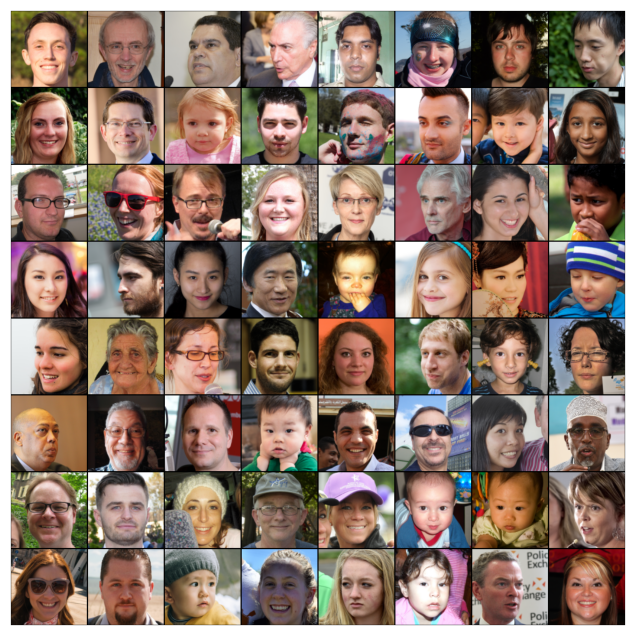

In [ ]:
show_batch(train_loader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 64 x 64

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
    )
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128 # choose latent size

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
    )

generator = to_device(generator, device)

torch.Size([64, 3, 128, 128])


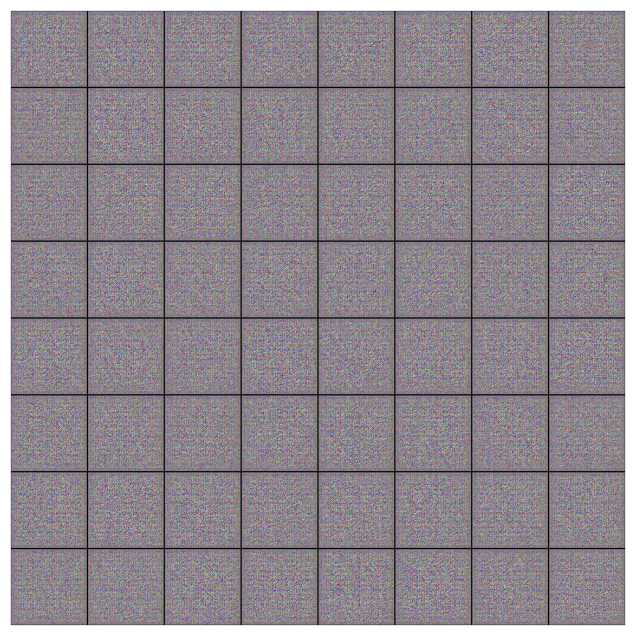

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = generator(xb).to('cpu')
print(fake_images.shape)
show_images(fake_images, latent_size)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001
epochs = 40
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(), lr=lr*3, betas=(0.5, 0.999))
    }

In [ ]:
from IPython.display import clear_output
import time

In [ ]:
def fit_epoch(model, criterion, optimizer):
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []
    for real_images, _ in tqdm(train_loader):
        optimizer["discriminator"].zero_grad()

        real_preds = model["discriminator"](real_images)
        real_targets = torch.ones(real_images.size(0), 1, device=device)
        real_loss = criterion["discriminator"](real_preds, real_targets)
        cur_real_score = torch.mean(real_preds).item()

        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](latent)

        fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
        fake_preds = model["discriminator"](fake_images.detach())
        fake_loss = criterion["discriminator"](fake_preds, fake_targets)
        cur_fake_score = torch.mean(fake_preds).item()

        real_score_per_epoch.append(cur_real_score)
        fake_score_per_epoch.append(cur_fake_score)

        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer["discriminator"].step()
        loss_d_per_epoch.append(loss_d.item())


        optimizer["generator"].zero_grad()

        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](latent)

        preds = model["discriminator"](fake_images)
        targets = torch.ones(batch_size, 1, device=device)
        loss_g = criterion["generator"](preds, targets)

        loss_g.backward()
        optimizer["generator"].step()
        loss_g_per_epoch.append(loss_g.item())

    loss_g_per_epoch = np.mean(loss_g_per_epoch)
    loss_d_per_epoch = np.mean(loss_d_per_epoch)
    real_score_per_epoch = np.mean(real_score_per_epoch)
    fake_score_per_epoch = np.mean(fake_score_per_epoch)
    return loss_g_per_epoch, loss_d_per_epoch, real_score_per_epoch, fake_score_per_epoch

In [ ]:
def res_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].plot(history['epoch'], history['losses_g'], label='losses_g')
    axes[0].plot(history['epoch'], history['losses_d'], label='losses_d')
    axes[0].legend()

    axes[1].plot(history['epoch'], history['real_scores'], label='real_scores')
    axes[1].plot(history['epoch'], history['fake_scores'], label='fake_scores')
    axes[1].legend()

In [ ]:
n_images = 4
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)

In [ ]:
def fit(model, criterion, optimizer, epochs):
    history = {'epoch':[],'losses_g':[], 'losses_d':[], 'real_scores':[], 'fake_scores':[]}
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        loss_g_per_epoch, loss_d_per_epoch, real_score_per_epoch, fake_score_per_epoch = fit_epoch(model, criterion, optimizer)
        history['epoch'].append(epoch+1)
        history['losses_g'].append(loss_g_per_epoch)
        history['losses_d'].append(loss_d_per_epoch)
        history['real_scores'].append(real_score_per_epoch)
        history['fake_scores'].append(fake_score_per_epoch)
        print(f'epoch {epoch+1}/{epochs}')
        print(f"losses_g: {history['losses_g'][-1]}, losses_d: {history['losses_d'][-1]}")
        print(f"real_scores: {history['real_scores'][-1]}, fake_scores' {history['fake_scores'][-1]}")

    return history

In [ ]:
history = fit(model, criterion, optimizer, epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1/40
losses_g: 2.9123388528823853, losses_d: 0.49497478365898134
real_scores: 0.8118592596054077, fake_scores' 0.18838554315268993


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 2/40
losses_g: 2.959546024799347, losses_d: 0.4738433319330215
real_scores: 0.8179722774028778, fake_scores' 0.1861024759709835


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 3/40
losses_g: 3.108038101196289, losses_d: 0.46372302144765853
real_scores: 0.8207021033763886, fake_scores' 0.17962975911796092


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 4/40
losses_g: 3.0354139184951783, losses_d: 0.5119111829996109
real_scores: 0.8099352639913558, fake_scores' 0.18244721505790948


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 5/40
losses_g: 2.9800692868232725, losses_d: 0.4770810949802399
real_scores: 0.8190767109394074, fake_scores' 0.1826924342662096


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 6/40
losses_g: 3.1136564016342163, losses_d: 0.4347915562987328
real_scores: 0.8319311988353729, fake_scores' 0.17020099759101867


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 7/40
losses_g: 3.236822336912155, losses_d: 0.5102038025856018
real_scores: 0.8127620685100555, fake_scores' 0.18398152567446233


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 8/40
losses_g: 3.0054239225387573, losses_d: 0.4677041757106781
real_scores: 0.8164101415872573, fake_scores' 0.17479427840560674


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 9/40
losses_g: 3.137251636981964, losses_d: 0.5155258947610855
real_scores: 0.811275172829628, fake_scores' 0.19009434662759303


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 10/40
losses_g: 3.0312318098545075, losses_d: 0.5012934499979019
real_scores: 0.812453351020813, fake_scores' 0.1863228787481785


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 11/40
losses_g: 3.0587551045417785, losses_d: 0.46808179616928103
real_scores: 0.8276375943422317, fake_scores' 0.17704694144427777


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 12/40
losses_g: 3.1131200289726255, losses_d: 0.44831848204135893
real_scores: 0.8275621223449707, fake_scores' 0.17009982652962208


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 13/40
losses_g: 3.1941109347343444, losses_d: 0.4801974993944168
real_scores: 0.8234450036287307, fake_scores' 0.17647072370164096


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 14/40
losses_g: 3.106093211174011, losses_d: 0.36950782805681226
real_scores: 0.8490136253833771, fake_scores' 0.1501188649237156


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 15/40
losses_g: 3.231505298614502, losses_d: 0.46203898966312407
real_scores: 0.8284480047225952, fake_scores' 0.1750163258984685


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 16/40
losses_g: 3.1766696858406065, losses_d: 0.4203536021709442
real_scores: 0.8355674290657044, fake_scores' 0.16199965201318264


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 17/40
losses_g: 3.2415414118766783, losses_d: 0.5119574284553527
real_scores: 0.8140800023078918, fake_scores' 0.1845582802593708


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 18/40
losses_g: 3.14658194065094, losses_d: 0.374283027946949
real_scores: 0.8479335629940032, fake_scores' 0.1505292111635208


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 19/40
losses_g: 3.130118374824524, losses_d: 0.3718270778656006
real_scores: 0.8515835309028625, fake_scores' 0.14780178591609


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 20/40
losses_g: 3.1449235820770265, losses_d: 0.6494722408056259
real_scores: 0.8018507906794548, fake_scores' 0.1935205888096243


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 21/40
losses_g: 3.1831801176071166, losses_d: 0.42997817605733873
real_scores: 0.8352382516860962, fake_scores' 0.1706751234829426


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 22/40
losses_g: 3.1895719504356386, losses_d: 0.36897642016410825
real_scores: 0.8496274030208588, fake_scores' 0.1474690879136324


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 23/40
losses_g: 3.2061907026171683, losses_d: 0.3965208575129509
real_scores: 0.8415908628702163, fake_scores' 0.148207886479795


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 24/40
losses_g: 3.1130984449386596, losses_d: 0.5006773215532303
real_scores: 0.8284732210636139, fake_scores' 0.17953379295766353


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 25/40
losses_g: 3.0044655990600586, losses_d: 0.325044666826725
real_scores: 0.8644479489326478, fake_scores' 0.1371307834237814


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 26/40
losses_g: 3.163476359844208, losses_d: 0.41957333773374555
real_scores: 0.8405490869283676, fake_scores' 0.15735188614577056


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 27/40
losses_g: 3.2289847683906556, losses_d: 0.34287154525518415
real_scores: 0.8616543364524841, fake_scores' 0.13997951325029134


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 28/40
losses_g: 3.2114313962310552, losses_d: 0.3878313085436821
real_scores: 0.8443277531862259, fake_scores' 0.1423870827257633


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 29/40
losses_g: 3.0443835854530334, losses_d: 0.6554670703411102
real_scores: 0.8103420609235763, fake_scores' 0.20184071145951749


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 30/40
losses_g: 3.180779321193695, losses_d: 0.3124838984012604
real_scores: 0.8681569528579712, fake_scores' 0.13141045056283474


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 31/40
losses_g: 3.2962858271598816, losses_d: 0.3592812970280647
real_scores: 0.8593063414096832, fake_scores' 0.13882977971807123


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 32/40
losses_g: 3.410323746204376, losses_d: 0.3495713523030281
real_scores: 0.8632614994049073, fake_scores' 0.13930301705375314


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 33/40
losses_g: 3.182044196128845, losses_d: 0.34680085748434064
real_scores: 0.8608659446239472, fake_scores' 0.13730799064040183


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 34/40
losses_g: 3.372996499538422, losses_d: 0.38294457107782365
real_scores: 0.8537440639734268, fake_scores' 0.14285313608124853


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 35/40
losses_g: 3.389454336166382, losses_d: 0.43384723901748656
real_scores: 0.8497658827900887, fake_scores' 0.15463867580518126


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 36/40
losses_g: 3.2848372769355776, losses_d: 0.3425436592102051
real_scores: 0.8616676032543182, fake_scores' 0.13807723805308342


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 37/40
losses_g: 3.3229897022247314, losses_d: 0.3322959592938423
real_scores: 0.8671971976757049, fake_scores' 0.12976464007049798


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 38/40
losses_g: 3.426230022907257, losses_d: 0.3867663387954235
real_scores: 0.8533410215377808, fake_scores' 0.14293192870449276


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 39/40
losses_g: 3.4193137884140015, losses_d: 0.36850211173295977
real_scores: 0.8595364993810654, fake_scores' 0.14042330000549555


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 40/40
losses_g: 3.3558324790000915, losses_d: 0.3465541860461235
real_scores: 0.8657091891765595, fake_scores' 0.13574637919664384


In [ ]:
torch.save(model["generator"].state_dict(), '/content/gdrive/MyDrive/generator.pth')
torch.save(model["discriminator"].state_dict(), '/content/gdrive/MyDrive/discriminator.pth')

In [ ]:
model["generator"].load_state_dict(torch.load('/content/gdrive/MyDrive/generator_1.pth'))
model["discriminator"].load_state_dict(torch.load('/content/gdrive/MyDrive/discriminator_1.pth'))


<ipython-input-23-4cf9ff1cc8bf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model["generator"].load_state_dict(torch.load('/content/gdrive/MyDrive/generator_1.pth'))
<i

<All keys matched successfully>

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

На графике представлен лосс за последние 40 эпох обучения, хотя сама модель обучалась около 100 эпох. График loss и score соответствует ожидаемым.

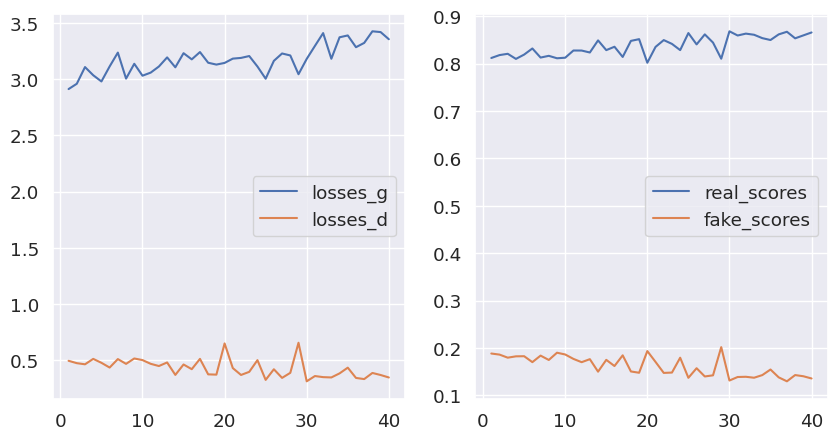

In [ ]:
res_history(history)

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

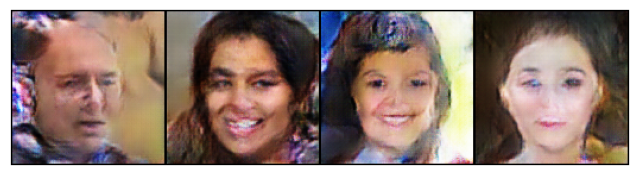

In [ ]:
show_gen_images(model["generator"], fixed_latent)

Как вам качество получившихся изображений?

Визуально выглядит достаточно неплохо, в целом, если прищуриться и наклонить голову, то даже похоже на реальные лица.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [ ]:
img = []
for data, _ in train_loader:
    img.append(data.cpu())

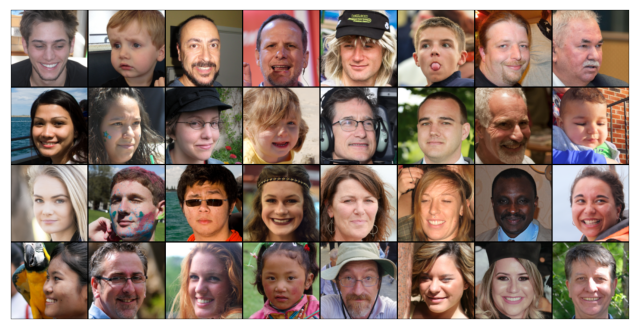

In [ ]:
img = torch.cat((img), 0)[:1000]
img_class = torch.ones(len(img), 1)
show_images(img, 32)

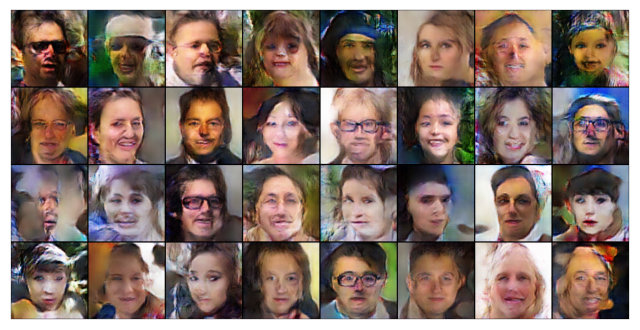

In [ ]:
gen = len(img)
latent = torch.randn(gen, latent_size, 1, 1, device=device)
fake = model["generator"](latent)
fake_class = torch.zeros(len(img), 1)
show_images(fake.cpu(), 32)

In [ ]:
X = np.concatenate((img.detach().cpu().numpy(), fake.detach().cpu().numpy()), 0)
Y = np.concatenate((img_class.detach().numpy(), fake_class.detach().numpy()), 0)

In [ ]:
X = X.reshape(X.shape[0], -1)
Y = Y.reshape(Y.shape[0])

In [ ]:
LOO = LeaveOneOut()

In [ ]:
accuracy = []
for train_index, test_index in LOO.split(X):
  knn = KNeighborsClassifier(1)
  xTrain = X[train_index]
  yTrain = Y[train_index]
  knn.fit(xTrain, yTrain)
  accuracy.append(accuracy_score(Y[test_index], knn.predict(X[test_index])))

In [ ]:
np.mean(accuracy)

0.541

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Идеальной точностью считается 0.5, когда невозможно отличить реальные изображения от сгенерированных. Конечно, человек визаульно легко может отличить сгенерированные картинки, однако, в нашем случае точность составляет 0.541, что говорит о довольно хорошей точности генерации картинок.

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
X = torch.cat((img.detach().cpu(), fake.detach().cpu()))
Y = torch.cat((img_class.detach(), fake_class.detach()))

In [ ]:
n_img = X.shape[0]
X = X.reshape(n_img,-1).numpy()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

X_tsne = TSNE(n_components=2).fit_transform(X)

In [ ]:
X_0 = X_tsne[:, 0].reshape(-1)
X_1 = X_tsne[:, 1].reshape(-1)
Y = Y.reshape(-1)

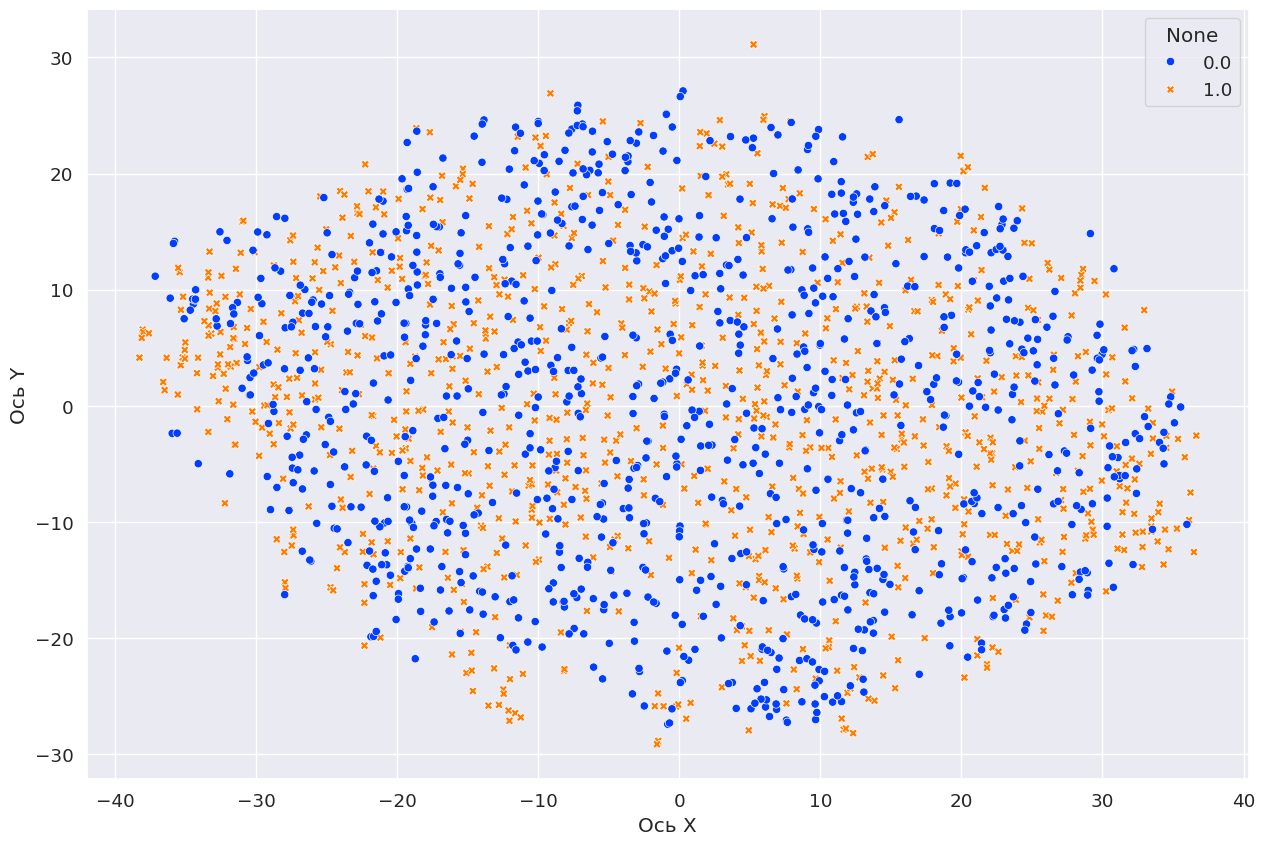

In [ ]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 10)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = X_0, y = X_1, hue=Y, palette='bright', style=Y)
ax.set_xlabel('Ось X')
ax.set_ylabel('Ось Y')
plt.show()

Прокомментируйте получившийся результат:

Как можно увидеть, реальные и сгенерированные изображения перемешаны и распределены примерно одинаково. Откуда можно сделать вывод, что изображения довольно похожи.

TSNE-распределение не позволяет чётко и однозначно разделить разные классы изображений.